In [1]:
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import numpy as np
from PlittGiocomo_CA1Morph_2019 import morph_analyses
pp = morph_analyses.preprocessing
u = morph_analyses.utilities 
ssm = morph_analyses.SimulatedSimMats

from matplotlib import pyplot as plt
import pickle
import os
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg
from sklearn.linear_model import LinearRegression as lreg
from sklearn.decomposition import PCA as pca
from scipy.optimize import minimize
import UnityTransforms as ut

# import SimulatedSimMats as ssm

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# get average priors from sfreg results
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'rb') as f:
    rare_sfreg = pickle.load(f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'rb') as f:
    freq_sfreg = pickle.load(f)

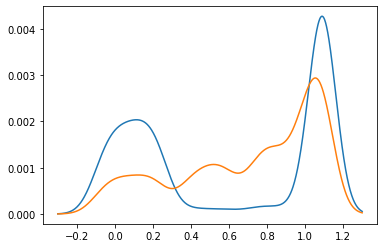

In [3]:
x=np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
rare_priors = np.zeros([len(rare_sfreg.keys()),x.shape[1]])
freq_priors =  np.zeros([len(freq_sfreg.keys()),x.shape[1]])
for i, (mouse,res) in enumerate(rare_sfreg.items()):
    _prior = res['priors'][0]
    _prior = _prior/_prior.sum()
    
    rare_priors[i,:]=_prior

rare_prior = rare_priors.mean(axis=0,keepdims=True)
rare_prior = rare_prior/rare_prior.sum()

for i, (mouse,res) in enumerate(freq_sfreg.items()):
    _prior = res['priors'][0]
    _prior = _prior/_prior.sum()
    
    freq_priors[i,:]=_prior

freq_prior = freq_priors.mean(axis=0,keepdims=True)
freq_prior = freq_prior/freq_prior.sum()

f,ax = plt.subplots()
ax.plot(x.ravel(),rare_prior.ravel())
ax.plot(x.ravel(),freq_prior.ravel())
# post_uc .= prior*gaussian(ut.wallmorphx(x.T),sigma_likelihood,x)
# post_uc = post_uc/post_uc.sum(axis=1,keepdims=True)

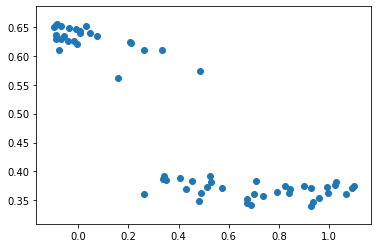

In [47]:
# load data from example mouse - get SF data
sf,wm = rare_sfreg['4343706']['sf'][-1],rare_sfreg['4343706']['wallmorph_uc'][-1]
# sf,wm = freq_sfreg['4343702.1']['sf'][-1],freq_sfreg['4343702.1']['wallmorph_uc'][-1]
f,ax = plt.subplots()
ax.scatter(wm,1-sf)

# example session

In [123]:
def calc_posterior_spline(prior, sigma):
    likelihood = u.gaussian(ut.wallmorphx(x.T),sigma,x)
    post = prior*likelihood
    post = post/post.sum(axis=1,keepdims=True)
    return post
    
    
def cost(params,sf,morph,post):
    alpha,beta= params
#     sf,morph,prior = args
#     post = calc_posterior_spline(prior,.3)
    aff_trans = np.clip(alpha*sf+beta,-1.3,1.3)
    
    morph_dig = np.digitize(morph,x.ravel())-1
    aff_trans_dig = np.digitize(aff_trans,x.ravel())-1
    
    
    prob = post[morph_dig,aff_trans_dig]
    return -np.log(prob).mean()

def get_prob(morph,yhat, post):
    morph_dig = np.digitize(morph,x.ravel())-1
    yhat_dig = np.digitize(yhat,x.ravel())-1
    
    
    prob = post[morph_dig,yhat_dig]
#     return -np.log(prob).mean()
    return -np.median(np.log(prob))





In [124]:
rare_post,freq_post = calc_posterior_spline(rare_prior,.3),calc_posterior_spline(freq_prior,.3)

In [125]:
freq_results,freq_prob,_,_ = sp.optimize.brute(cost,((2,20),(-10,0)),args=(sf,wm,freq_post),Ns=50,finish = sp.optimize.minimize,full_output=True)
rare_results,rare_prob,_,_ = sp.optimize.brute(cost,((2,20),(-10,0)),args=(sf,wm,rare_post),Ns=50,finish = sp.optimize.minimize,full_output=True)

In [126]:
print(rare_results,freq_results)
print(-freq_prob,-rare_prob)
print((rare_prob-freq_prob))

[20.        -9.3877551] [17.06122449 -7.95918367]
-5.918130928653319 -6.524562651324482
0.6064317226711626


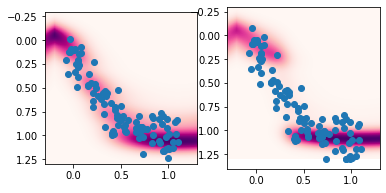

In [127]:
f,ax = plt.subplots(1,2)
ax[0].imshow(freq_post.T,extent=[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[0].scatter(wm,np.clip(sf*freq_results[0]+freq_results[1],-1.3,1.3))

ax[1].imshow(rare_post.T,extent=[-.3,1.3,1.3,-.3],cmap='RdPu')
ax[1].scatter(wm,np.clip(sf*rare_results[0]+rare_results[1],-1.3,1.3))

C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


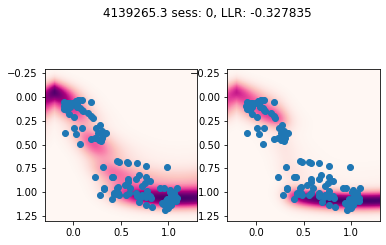

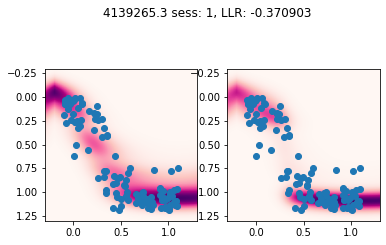

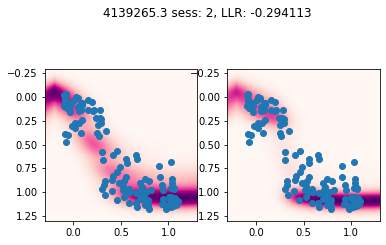

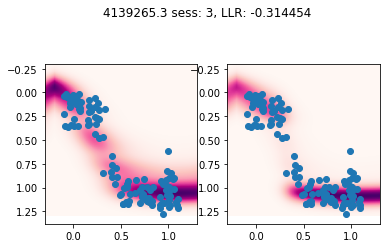

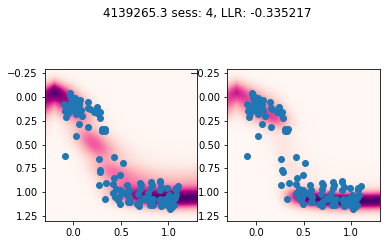

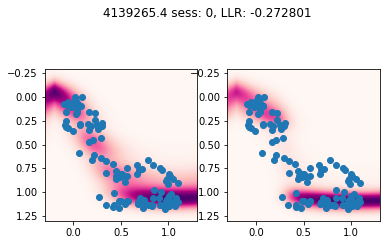

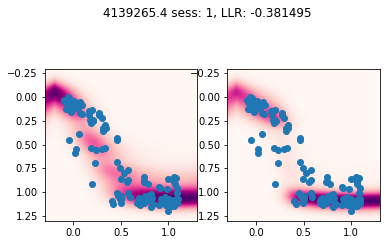

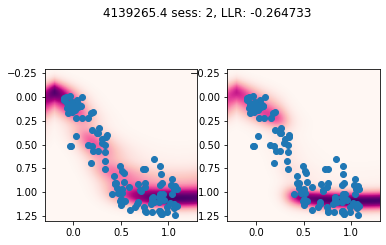

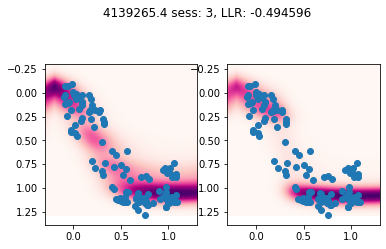

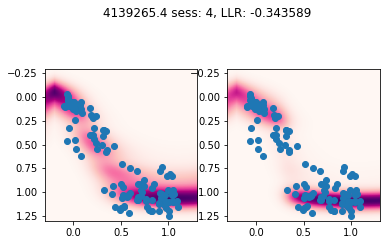

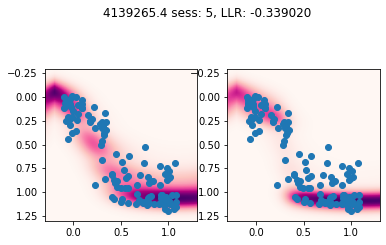

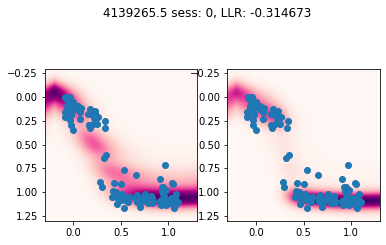

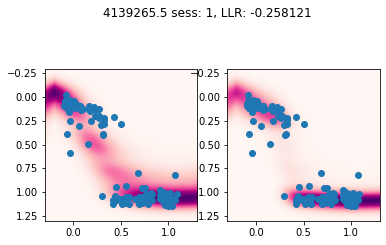

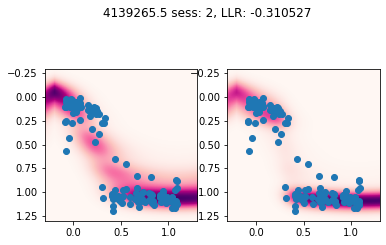

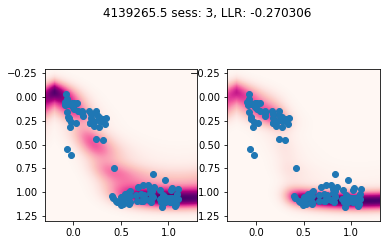

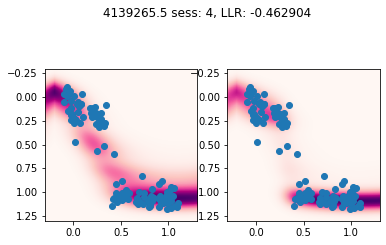

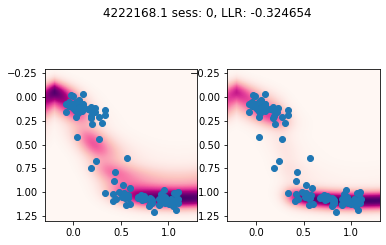

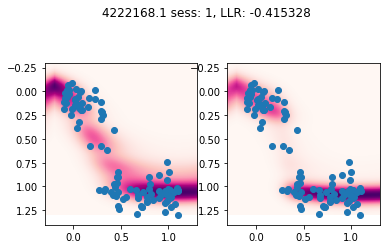

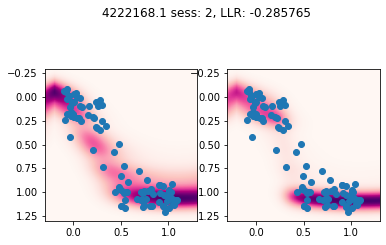

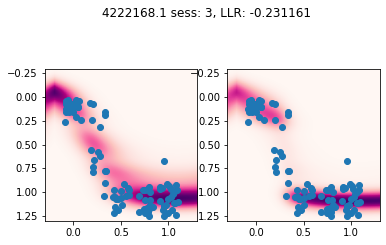

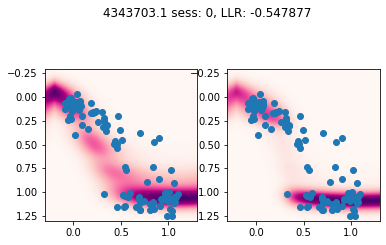

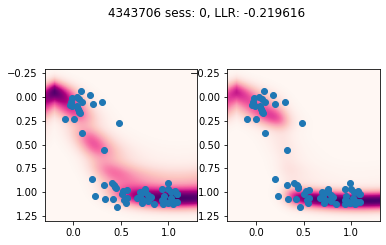

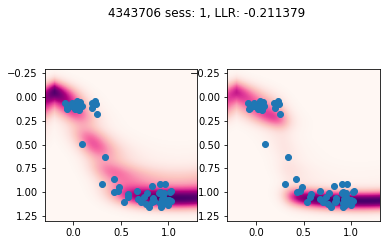

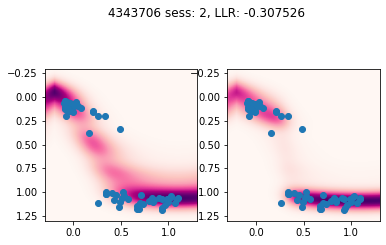

In [128]:
rare_LLR = {}
for mouse,res in rare_sfreg.items():
    rare_LLR[mouse]=[]
    for i, (sf, wm,yhat) in enumerate(zip(res['sf'],res['wallmorph_uc'],res['rare_yhat'])):
#         freq_results,freq_prob,_,_ = sp.optimize.brute(cost,((2,20),(-10,0)),args=(sf,wm,freq_post),Ns=50,finish = sp.optimize.minimize,full_output=True)
#         rare_results,rare_prob,_,_ = sp.optimize.brute(cost,((2,20),(-10,0)),args=(sf,wm,rare_post),Ns=50,finish = sp.optimize.minimize,full_output=True)
        
        rare_prob, freq_prob = get_prob(wm,yhat,rare_post), get_prob(wm,yhat,freq_post)
        f,ax = plt.subplots(1,2)
        ax[0].imshow(freq_post.T,extent=[-.3,1.3,1.3,-.3],cmap='RdPu')
        ax[0].scatter(wm,yhat)
#         ax[0].scatter(wm,np.clip(sf*freq_results[0]+freq_results[1],-1.3,1.3))

        ax[1].imshow(rare_post.T,extent=[-.3,1.3,1.3,-.3],cmap='RdPu')
        ax[1].scatter(wm,yhat)
#         ax[1].scatter(wm,np.clip(sf*rare_results[0]+rare_results[1],-1.3,1.3))
        f.suptitle("%s sess: %i, LLR: %f" % (mouse, i,rare_prob-freq_prob) )
    
        rare_LLR[mouse].append(rare_prob-freq_prob)

C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


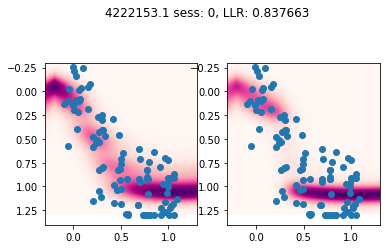

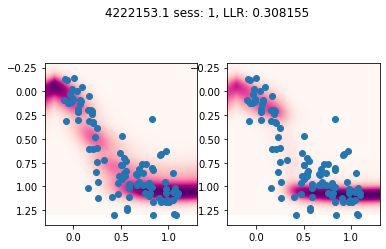

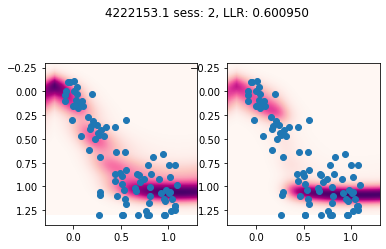

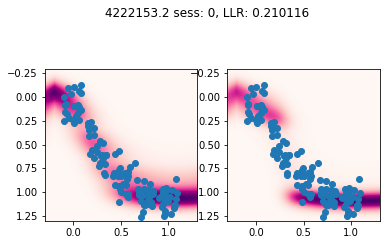

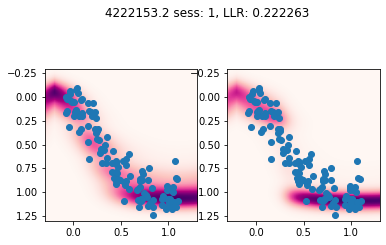

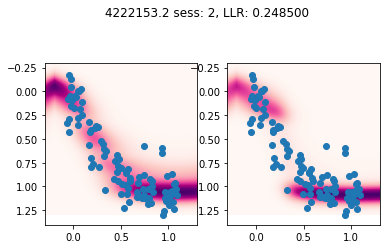

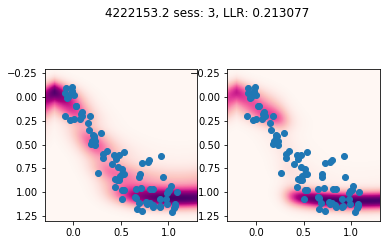

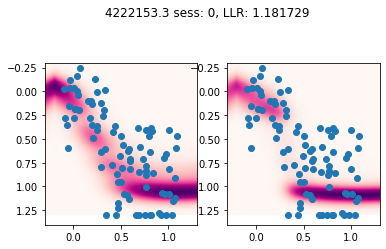

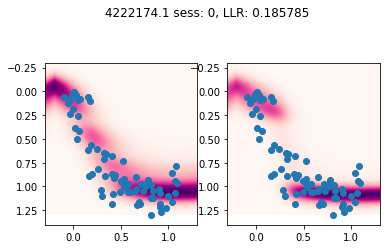

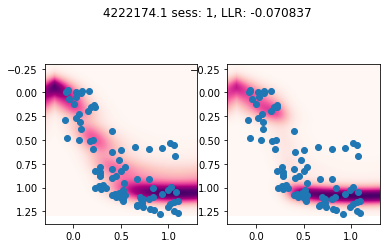

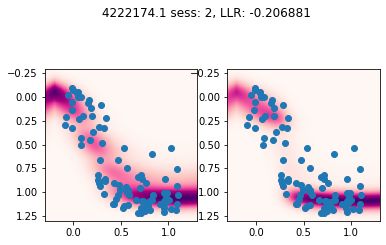

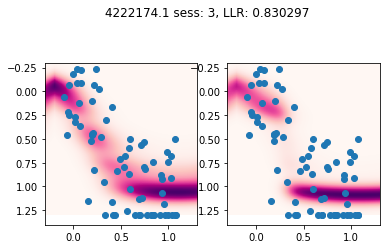

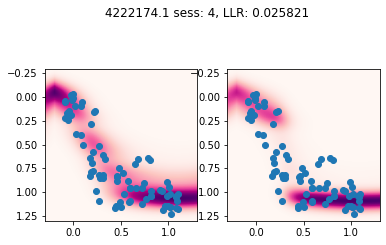

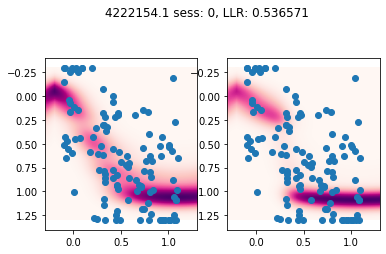

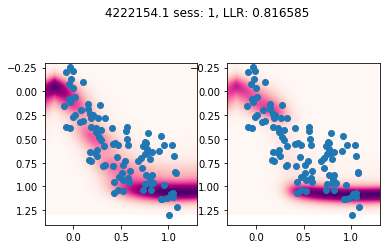

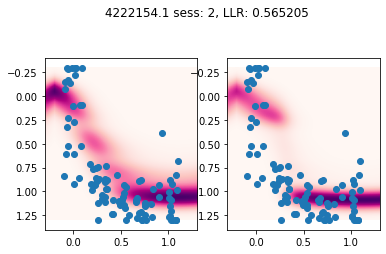

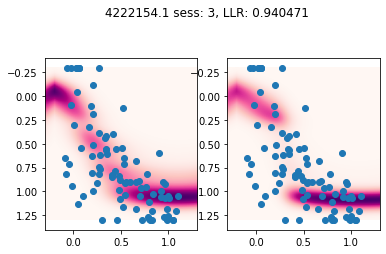

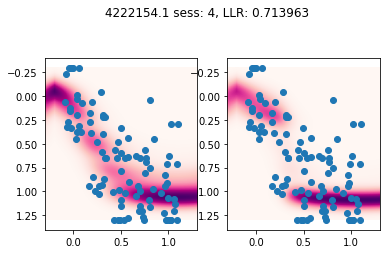

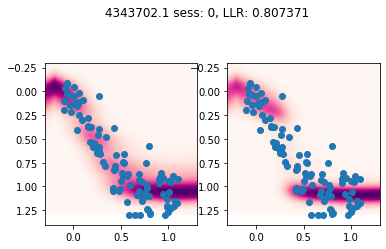

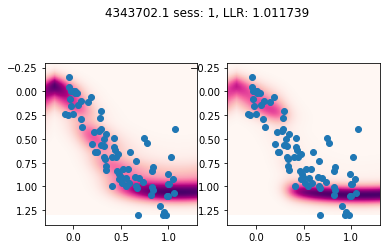

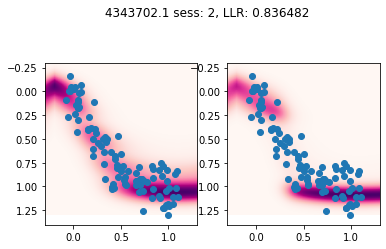

In [131]:
freq_LLR = {}
for mouse,res in freq_sfreg.items():
    freq_LLR[mouse]=[]
    for i, (sf, wm,yhat) in enumerate(zip(res['sf'],res['wallmorph_uc'],res['rare_yhat'])):
#         freq_results,freq_prob,_,_ = sp.optimize.brute(cost,((2,20),(-10,0)),args=(sf,wm,freq_post),Ns=50,finish = sp.optimize.minimize,full_output=True)
#         rare_results,rare_prob,_,_ = sp.optimize.brute(cost,((2,20),(-10,0)),args=(sf,wm,rare_post),Ns=50,finish = sp.optimize.minimize,full_output=True)
        
        rare_prob, freq_prob = get_prob(wm,yhat,rare_post), get_prob(wm,yhat,freq_post)
        f,ax = plt.subplots(1,2)
        ax[0].imshow(freq_post.T,extent=[-.3,1.3,1.3,-.3],cmap='RdPu')
        ax[0].scatter(wm,yhat)
#         ax[0].scatter(wm,np.clip(sf*freq_results[0]+freq_results[1],-1.3,1.3))

        ax[1].imshow(rare_post.T,extent=[-.3,1.3,1.3,-.3],cmap='RdPu')
        ax[1].scatter(wm,yhat)
#         ax[1].scatter(wm,np.clip(sf*rare_results[0]+rare_results[1],-1.3,1.3))
        f.suptitle("%s sess: %i, LLR: %f" % (mouse, i,rare_prob-freq_prob) )
    
        freq_LLR[mouse].append(rare_prob-freq_prob)

4139265.3 [-0.32783469517768715, -0.3709032754705559, -0.2941129787944359, -0.31445420501863275, -0.33521659695476114]
4139265.4 [-0.27280132663067036, -0.3814954847739438, -0.26473280716971814, -0.49459572598648904, -0.3435887006455971, -0.3390195161366014]
4139265.5 [-0.3146725049571675, -0.2581210855936167, -0.3105266671559379, -0.27030581720179914, -0.46290363098377707]
4222168.1 [-0.32465446036225565, -0.41532764348627804, -0.28576496015820485, -0.2311610924532479]
4343703.1 [-0.547877096657337]
4343706 [-0.21961579391807895, -0.21137914561691495, -0.30752602586375133]
4222153.1 [0.8376627522914379, 0.3081546796303467, 0.6009498155075992]
4222153.2 [0.2101162197351325, 0.2222628654320289, 0.2485000436032596, 0.21307712526620914]
4222153.3 [1.1817294137011114]
4222174.1 [0.18578516754088792, -0.07083743016004451, -0.2068808546783334, 0.8302974407104067, 0.025820857497629746]
4222154.1 [0.5365712459333096, 0.8165854854100649, 0.5652046188354429, 0.9404709053707734, 0.713963281607639

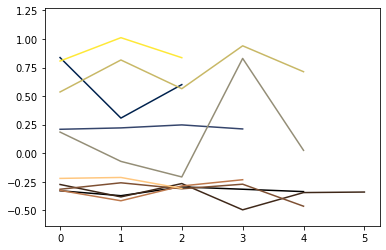

In [132]:
f,ax = plt.subplots()
for i, (mouse,llr) in enumerate(rare_LLR.items()):
    print(mouse,llr)
    ax.plot(np.arange(len(llr)),llr,color=plt.cm.copper(i/5.))
    
for i, (mouse,llr) in enumerate(freq_LLR.items()):
    print(mouse,llr)
    ax.plot(np.arange(len(llr)),llr,color=plt.cm.cividis(i/5.))